# ПРОГНОЗИРОВАНИЕ ОТТОКА КЛИЕНТОВ

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Услуги

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Данные для исследования


Данные состоят из файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

### План проекта


Цель проекта - обучить модель, предсказывающую уход клиента с ROC-AUC не менее 0.9.

ПЛАН РАБОТЫ

1. Провести исследовательский анализ данных, посмотреть на типы данных, пропуски, частоту классов.
2. Создать новые признаки, проверить на коллинеарность, удалить избыточные или бесполезные столбцы.
3. Определиться с метрикой.
4. Подготовить выборки для обучения, валидации и тестирования.
5. Прикрутить пайплайны?
6. Стандартизировать данные.
7. Обучить модели, выбрать лучшую.
8. Проверить лучшую модель на тестовой выборке.

## Знакомство с данными

In [2]:
from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import os

In [3]:
path = '/datasets' if os.path.exists("/datasets") else "./"

contract_df = pd.read_csv(f'{path}/contract_new.csv')
personal_df = pd.read_csv(f'{path}/personal_new.csv')
internet_df = pd.read_csv(f'{path}/internet_new.csv')
phone_df = pd.read_csv(f'{path}/phone_new.csv')

In [4]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
for col in contract_df.columns:
    print(col, contract_df[col].unique(), '\n')

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

BeginDate ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-1

In [7]:
contract_df.duplicated().sum()

0

In [8]:
contract_df['Type'].count()

7043

In [9]:
(contract_df['EndDate'] == 'No').sum()

5942

In [10]:
contract_df[contract_df['EndDate'] == 'No'].count()

customerID          5942
BeginDate           5942
EndDate             5942
Type                5942
PaperlessBilling    5942
PaymentMethod       5942
MonthlyCharges      5942
TotalCharges        5942
dtype: int64

In [11]:
# contract_df.rename(columns={'customerID': 'CustomerID'}, inplace=True)

Из 7 тысяч объектов у нас чуть больше тысячи объектов целевого класса.

In [12]:
contract_df.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [13]:
contract_df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [14]:
CURRENT_DATE = "2020-02-01"

In [15]:
t = contract_df.copy()
t['BeginDate'] = pd.to_datetime(t['BeginDate'])
t.loc[t['EndDate'] == 'No', 'EndDate'] = CURRENT_DATE
t['EndDate'] = pd.to_datetime(t['EndDate'])
t.dropna(subset=['EndDate'], inplace=True)
t['EndDate'].isna().sum()

0

<AxesSubplot: title={'center': 'Время жизни клиента (дней)'}>

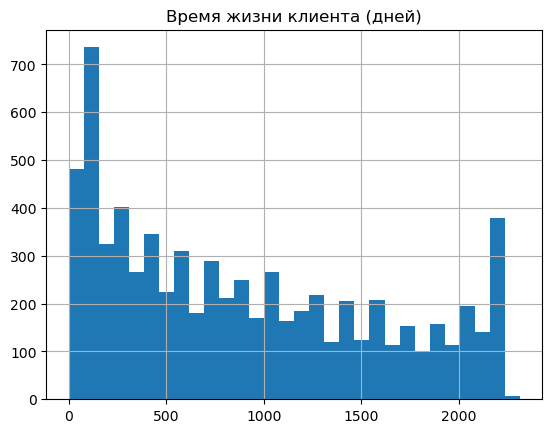

In [16]:
duration = (t['EndDate'] - t['BeginDate']).dt.days
plt.title("Время жизни клиента (дней)")
duration.hist(bins=30)

In [17]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [18]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [19]:
for col in phone_df.columns:
    print(col, phone_df[col].unique(), '\n')

customerID ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK'] 

MultipleLines ['No' 'Yes'] 



In [20]:
phone_df.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [21]:
for col in phone_df.columns:
    print(col, phone_df[col].unique(), '\n')

customerID ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK'] 

MultipleLines ['No' 'Yes'] 



In [22]:
phone_df.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [23]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [24]:
for col in internet_df.columns:
    print(col, internet_df[col].unique(), '\n')

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

InternetService ['DSL' 'Fiber optic'] 

OnlineSecurity ['No' 'Yes'] 

OnlineBackup ['Yes' 'No'] 

DeviceProtection ['No' 'Yes'] 

TechSupport ['No' 'Yes'] 

StreamingTV ['No' 'Yes'] 

StreamingMovies ['No' 'Yes'] 



In [25]:
internet_df.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [26]:
phone_df.duplicated().sum()

0

In [27]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [28]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [29]:
contract_df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [30]:
personal_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [31]:
internet_df.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [32]:
phone_df.columns

Index(['customerID', 'MultipleLines'], dtype='object')

In [33]:
internet_df.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [34]:
internet_df.duplicated().sum()

0

In [35]:
internet_df.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [36]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [37]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [38]:
personal_df.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [39]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [40]:
personal_df.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [41]:
personal_df.duplicated().sum()

0

In [42]:
personal_df.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

<AxesSubplot: title={'center': 'PaymentMethod'}>

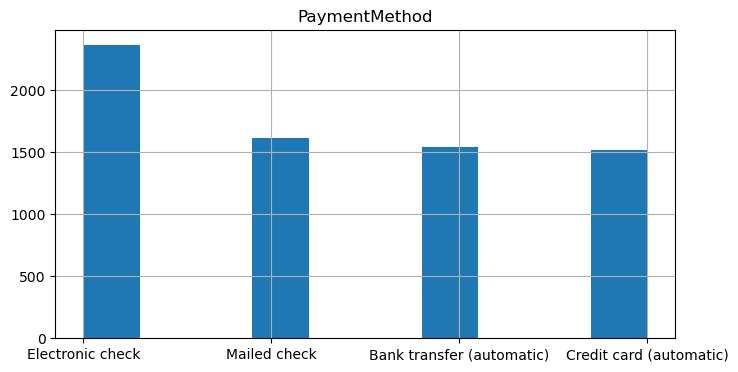

In [43]:
plt.title("PaymentMethod")
contract_df['PaymentMethod'].hist(figsize=[8, 4])


<AxesSubplot: title={'center': 'Type'}>

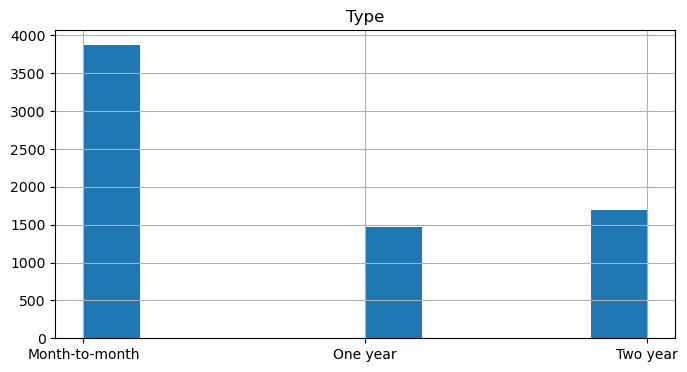

In [44]:
plt.title("Type")
contract_df['Type'].hist(figsize=[8, 4])

In [45]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


<AxesSubplot: title={'center': 'Gender'}>

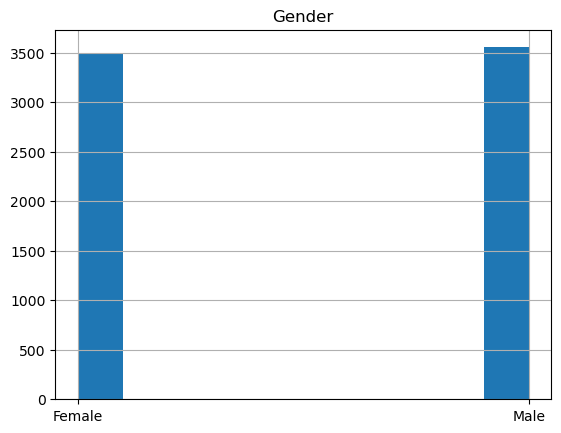

In [46]:
plt.title("Gender")
personal_df['gender'].hist()

<AxesSubplot: title={'center': 'Dependents'}>

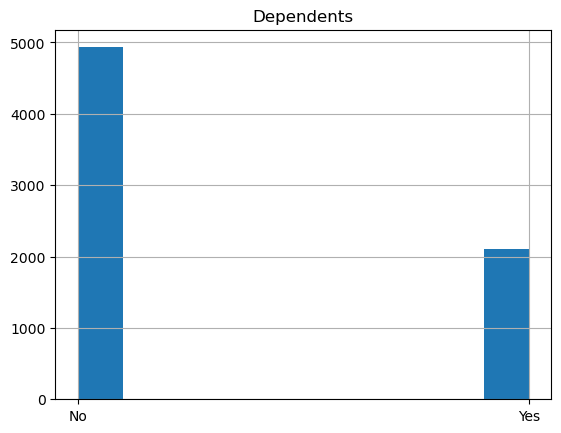

In [47]:
plt.title("Dependents")
personal_df['Dependents'].hist()

<AxesSubplot: title={'center': 'SeniorCitizen'}>

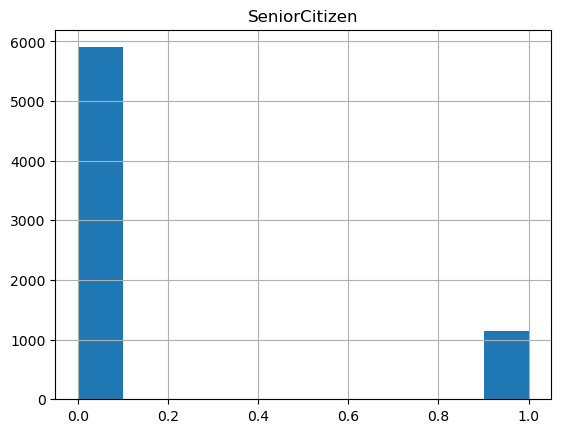

In [48]:
plt.title("SeniorCitizen")
personal_df['SeniorCitizen'].hist()

Ожидаемо дедов поменьше.

<AxesSubplot: title={'center': 'Partner'}>

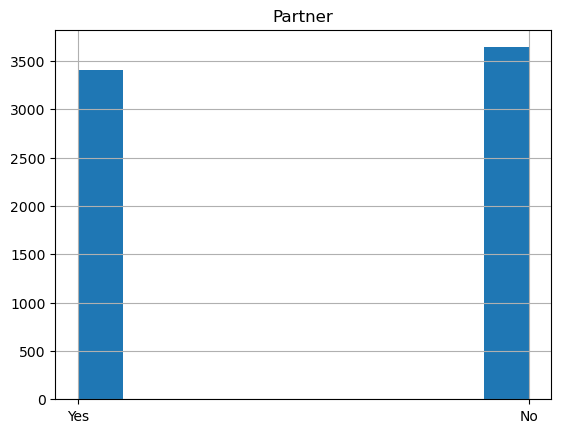

In [49]:
plt.title("Partner")
personal_df['Partner'].hist()

### Классы

У нас 2 класса - целевой класс ушедших клиентов и нецелевой класс лояльных покупателей. В датасете наблюдается дисбаланс классов - целевого класса примерно в 6 раз меньше.

In [50]:
merged_df = pd.merge(phone_df, personal_df, on='customerID', how='outer')
merged_df = pd.merge(merged_df, internet_df, on='customerID', how='outer')
merged_df = pd.merge(merged_df, contract_df, on='customerID', how='outer')
merged_df.set_index('customerID', inplace=True)

In [51]:
# Our target
merged_df['Churn'] = merged_df['EndDate'].apply(lambda x: "Остался" if x == "No" else "Ушёл")
merged_df['Churn'].isna().sum()

0

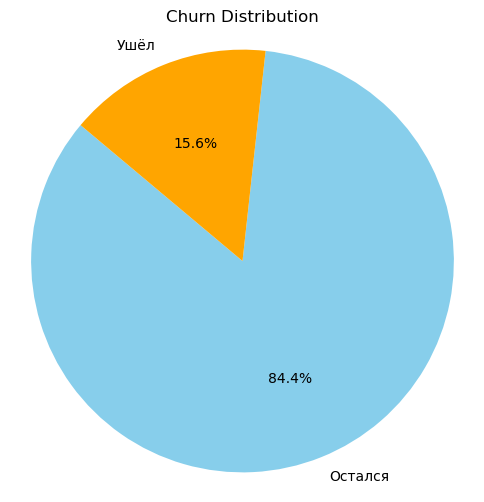

In [52]:

# Assuming merged_df contains a 'Churn' column
churn_counts = merged_df['Churn'].value_counts()
labels = churn_counts.index
sizes = churn_counts.values

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Churn Distribution')
plt.show()


Наблюдаем дисбаланс

### Заключение по результатам первичного ознакомления с данными

Файл 'contract_new.csv' содержит 7043 строки и включает столбцы customerID, BeginDate (дата подписания контракта с клиентом), EndDate (дата окончания контракта с клиентом, если контракт действующий, то в ячейке строка "No"), Type, PaperlessBilling, PaymentMethod, TotalCharges типа
object и столбец MonthlyCharges типа float. TotalCharges стоит привести к типу float.
Явных дубликатов не обнаружено.


Файл 'file_new.csv' содержит 2 столбца типа object customerID с id клиента и MultipleLines, содержащий строки "Yes" и "No" (можно сменить тип на булевый).
Явных дубликатов нет.
6361 строка.

Файл 'internet_new' включает столбцы 	customerID,	InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV,
StreamingMovies, все столбцы типа object. Все столбцы, кроме первых двух, можно перевести в тип bool.
Явных дубликатов нет.
5517 строк.

Файл 'personal_new.csv' содержит столбцы customerID, gender, SeniorCitizen, Partner, Dependents, почти все столбцы типа object, только столбец SeniorCitizen типа int. Все столбцы, кроме id, можно привести к типу bool.
Явных дубликатов нет.
7043 строки.

На данном этапе вопросов нет.

## Подготовка данных


In [53]:
path = '/datasets' if os.path.exists("/datasets") else "./"

contract_df = pd.read_csv(f'{path}/contract_new.csv')
personal_df = pd.read_csv(f'{path}/personal_new.csv')
internet_df = pd.read_csv(f'{path}/internet_new.csv')
phone_df = pd.read_csv(f'{path}/phone_new.csv')

In [54]:
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors='coerce')
contract_df['TotalCharges'].isna().sum()

11

In [55]:
contract_df.dropna(subset=['TotalCharges'], inplace=True)
contract_df['TotalCharges'].isna().sum()

0

In [56]:
merged_df = pd.merge(phone_df, personal_df, on='customerID', how='outer')
merged_df = pd.merge(merged_df, internet_df, on='customerID', how='outer')
merged_df = pd.merge(merged_df, contract_df, on='customerID', how='outer')
merged_df.set_index('customerID', inplace=True)

In [57]:
# Our target
merged_df['Churn'] = merged_df['EndDate'].apply(lambda x: 0 if x == "No" else 1)
merged_df['Churn'].isna().sum()

0

In [58]:
# convert BeginDate and EndDate

merged_df['BeginDate'] = pd.to_datetime(merged_df['BeginDate'])
merged_df.dropna(subset=['EndDate'], inplace=True)
merged_df['EndDate'].isna().sum()
merged_df.loc[merged_df['EndDate'] == 'No', 'EndDate'] = CURRENT_DATE
merged_df['EndDate'] = pd.to_datetime(merged_df['EndDate'])
merged_df['EndDate'].isna().sum()

0

In [59]:
print("Количество ушедших клиентов", merged_df.Churn.sum())

Количество ушедших клиентов 1101


In [60]:
# Добавим признак "время жизни клиента"

merged_df['Tenure'] = (merged_df['EndDate'] - merged_df['BeginDate']).dt.days

merged_df.drop(['BeginDate', 'EndDate'], axis=1, inplace=True)

In [61]:
# категориальные признаки

categorical_features = merged_df.select_dtypes(include=['object']).columns.tolist()
categorical_features


['MultipleLines',
 'gender',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Type',
 'PaperlessBilling',
 'PaymentMethod']

In [62]:
# в каких категориальных признаках имеются NaN-ы после объединения таблиц?

categorical_features_with_nan = []

for feature in categorical_features:
    if merged_df[feature].isnull().any():
        categorical_features_with_nan.append(feature)

print(categorical_features_with_nan)


['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']


In [63]:
# Эти наны связаны с отстувием подключенных услуг. Заполим их "NoService"

for feature in categorical_features:
    merged_df[feature].fillna("NoService", inplace=True)


In [64]:
# К сожалению, обычные фичи оказались недостаточны для обучения простых моделей
# Придётся расширить их нелиейностями

# Добавим деление:

ratio = merged_df["TotalCharges"] / merged_df["MonthlyCharges"]
merged_df["ChargesRatio"] = ratio
ratio.describe()

# Также потом добавим квадраты, но сделаем это после нормализации

count    7032.000000
mean       30.357378
std        23.074504
min         1.000000
25%         9.270006
50%        26.000000
75%        48.970075
max        79.200000
dtype: float64

In [66]:
merged_df.describe()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,Tenure,ChargesRatio
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,64.798208,2118.621822,0.156570,899.961320,30.357378
std,0.368844,30.085974,2112.736199,0.363421,682.738777,23.074504
min,0.000000,18.250000,19.050000,0.000000,28.000000,1.000000
25%,0.000000,35.587500,439.745000,0.000000,276.000000,9.270006
50%,0.000000,70.350000,1345.275000,0.000000,761.000000,26.000000
75%,0.000000,89.862500,3239.317500,0.000000,1461.000000,48.970075
max,1.000000,118.750000,9221.380000,1.000000,2314.000000,79.200000


In [67]:
numeric_features = "SeniorCitizen	MonthlyCharges	TotalCharges	Churn	Tenure	ChargesRatio".split()
numeric_features

['SeniorCitizen',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'Tenure',
 'ChargesRatio']

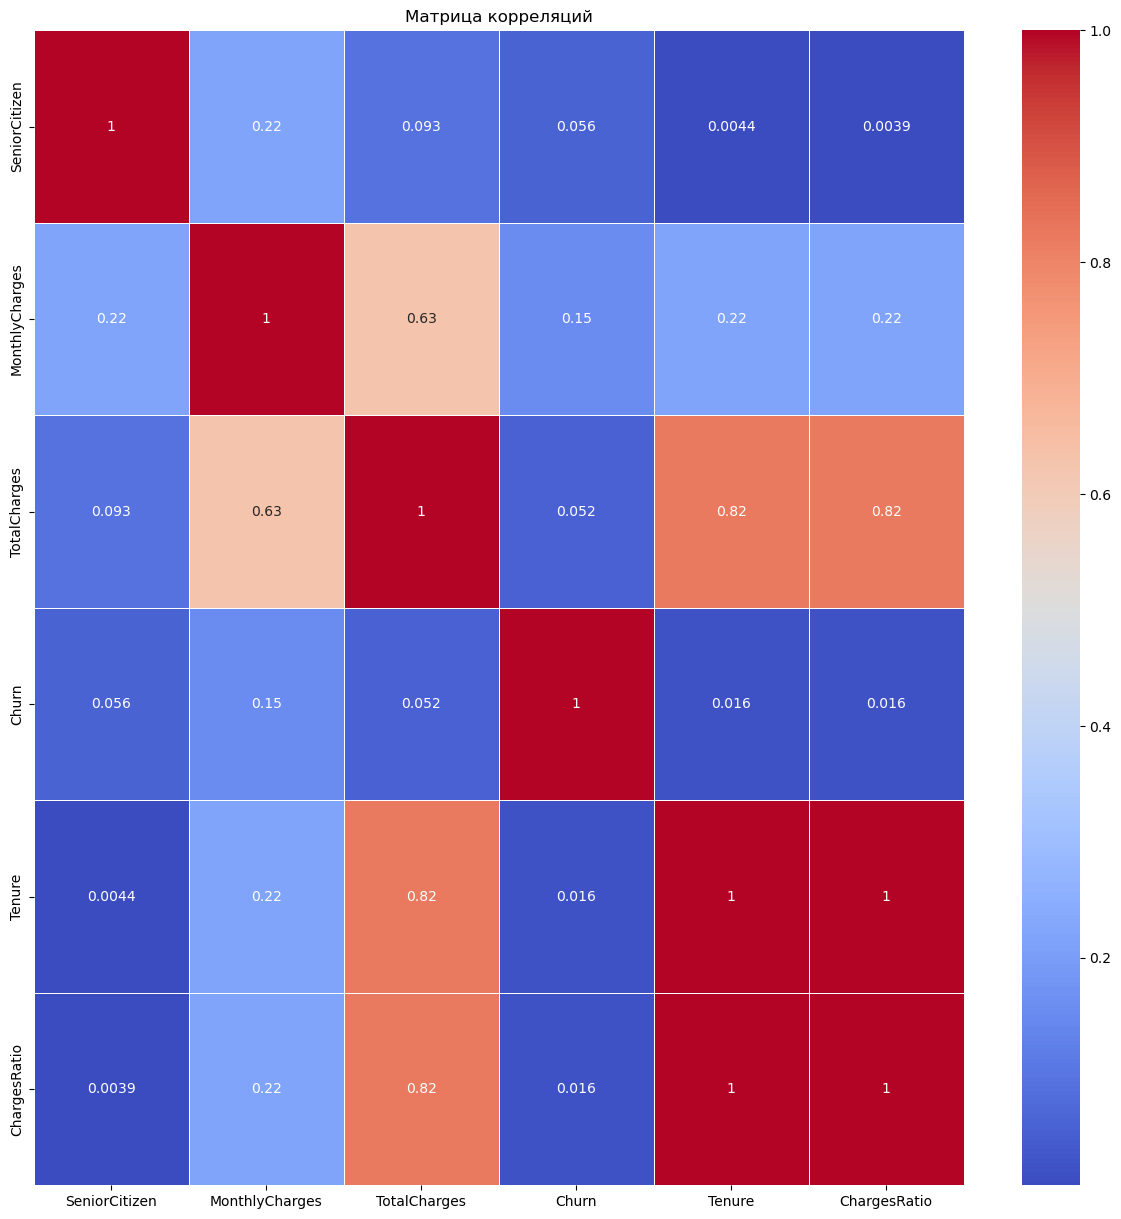

In [68]:
# Визуализация матрицы корреляций с использованием seaborn

correlation_matrix = merged_df[numeric_features].corr()

plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляций')
plt.show()


Интересно, что время жизни клиента сильно коррелирует с отношением TotalCharges к MonthlyCharges. Удалим отношение

In [69]:
# удалим колл признак
merged_df = merged_df.drop(columns=["ChargesRatio"])


In [72]:
# Расширим выборку ещё и квадратами

squared_features = ['MonthlyCharges', 'TotalCharges', 'Tenure']

for feature in squared_features:
    merged_df[f'{feature}_squared'] = merged_df[feature] ** 2


In [73]:
# Разделим выборку на обучающую и тестовую
# Обучим скейлинг на обучающей и применим к тестовой
# После этого мы сможем разделить тестовую на тестовую и валидационную, по которой выберем лучшую модель

# Create X and y
X = merged_df.copy().drop(['Churn'], axis=1)
y = merged_df.copy().Churn

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=40823, stratify=y)

print("Соотношение классов (трейн, тест):", (sum(y_train)/len(y_train), sum(y_test)/len(y_test)))

Соотношение классов (трейн, тест): (0.15661736822146377, 0.15642775881683732)


In [74]:
X_train.head()

,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,StreamingMovies,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Tenure,MonthlyCharges_squared,TotalCharges_squared,Tenure_squared
customerID,,,,,,,,,,,,,,,,,,,,,
5914-XRFQB,Yes,Male,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,...,Yes,Two year,Yes,Bank transfer (automatic),115.80,8504.35,2191,13409.6400,7.232397e+07,4800481
2840-XANRC,No,Male,1,Yes,No,Fiber optic,No,No,Yes,No,...,Yes,Month-to-month,Yes,Electronic check,93.15,2421.90,792,8676.9225,5.865600e+06,627264
5088-QZLRL,No,Male,0,No,No,NoService,NoService,NoService,NoService,NoService,...,NoService,Month-to-month,No,Electronic check,20.65,21.27,31,426.4225,4.524129e+02,961
9600-UDOPK,Yes,Male,0,Yes,No,Fiber optic,No,No,No,No,...,Yes,Month-to-month,Yes,Credit card (automatic),94.05,3003.02,945,8845.4025,9.018129e+06,893025
4732-RRJZC,No,Male,0,Yes,Yes,NoService,NoService,NoService,NoService,NoService,...,NoService,Month-to-month,No,Mailed check,20.25,151.67,215,410.0625,2.300379e+04,46225


Можно добавить и другие полиномиальные признаки, но это может усилить переобучению

## Обучение моделей

### Логистическая регрессия

In [77]:
# Define a list of candidate values for the parameter C
param_grid = {'logreg__C': [
    0.001,
    0.005,
    0.010,
    0.050,
    0.100,
    0.500,
    0.750,
    0.900,
    1.000,
    1.100,
    2.000,
    2.250,
    2.500,
    3.000,
    5.000,
    10.00,
    50.00,
    100.0,
]}

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough',  # Pass through any remaining columns
    verbose_feature_names_out=True
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=5000, class_weight='balanced'))
]) 

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['MultipleLines',
                                                                          'gender',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=5000))]),
             param_grid={'logreg__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.75,
                                       0.9, 1.0, 1.1, 2.0, 2.25, 2.5, 3.0, 5.0,
                                       10.0, 50.0, 100.0]},
             scoring='roc_auc')

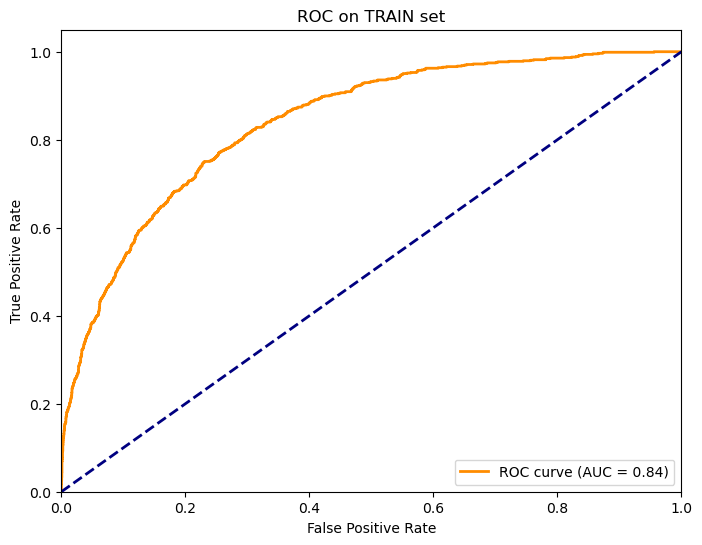

In [78]:
best_estimator = grid_search.best_estimator_
y_prob = best_estimator.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_prob)
roc_auc = roc_auc_score(y_train, y_prob)
best_auc_logreg_train = roc_auc

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on TRAIN set')
plt.legend(loc='lower right')
plt.show()

In [79]:
grid_search.scorer_

make_scorer(roc_auc_score, needs_threshold=True)

In [80]:
best_logreg_C = grid_search.best_params_['logreg__C']
best_logreg_score = grid_search.best_score_

print(f"Best C value: {best_logreg_C}")
print(f"Best cross-validated score: {best_logreg_score:.4f}")

Best C value: 0.9
Best cross-validated score: 0.8297


### LGBM

In [81]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import numpy as np

# Create a LightGBM classifier object
lgbm_classifier = lgb.LGBMClassifier(objective='binary', metric='auc', boosting_type='gbdt')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('model', lgbm_classifier)
]) 

# Define the hyperparameters and their distributions
param_dist = {
    'model__max_depth': np.arange(3, 60, 5),
    'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'model__feature_fraction': np.linspace(0.10, 0.50, 6),
    'model__lambda_l2': np.linspace(0.01, 10.0, 100)
}

random_search_lgbm = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=2,
#     verbose=10,
    random_state=40823
)

# Fit the model
random_search_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=3.1381818181818177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1381818181818177
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=3.1381818181818177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1381818181818177
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 413, number of negative: 2224
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the o

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['MultipleLines',
                                                                                'gender',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'InternetService',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'StreamingTV',
                                                                                'StreamingMovies',
                                                                                'Type',
                                                                                'PaperlessBilling',
                                                                                'Pa...
        8.08272727,  8.18363636,  8.28454545,  8.38545455,  8.48636364,
        8.58727273,  8.68818182,  8.78909091,  8.89      ,  8.99090909,
        9.09181818,  9.19272727,  9.29363636,  9.39454545,  9.49545455,
        9.59636364,  9.69727273,  9.79818182,  9.89909091, 10.        ]),
                                        'model__learning_rate': [0.001, 0.01,
                                                                 0.05, 0.1, 0.2,
                                                                 0.3],
                                        'model__max_depth': array([ 3,  8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58])},
                   random_state=40823, scoring='roc_auc')

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=1.7254545454545454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7254545454545454
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


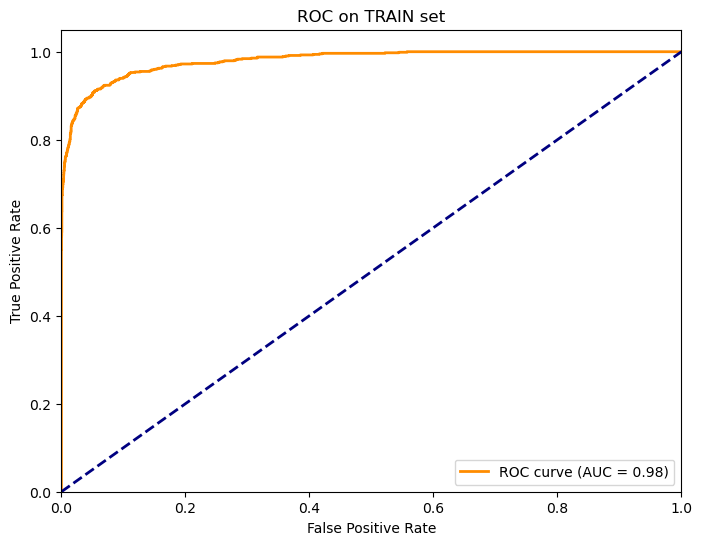

In [82]:
best_estimator = random_search_lgbm.best_estimator_
y_prob = best_estimator.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_prob)
best_lgbm_rocauc_train = roc_auc = roc_auc_score(y_train, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on TRAIN set')
plt.legend(loc='lower right')
plt.show()

In [83]:
random_search_lgbm.scorer_

make_scorer(roc_auc_score, needs_threshold=True)

In [84]:
# Best hyperparameters from the search
best_params_lgbm = random_search_lgbm.best_params_
best_score_lgbm = random_search_lgbm.best_score_

print("LGBM best params", best_params_lgbm)
print(f"LGBM best score", best_score_lgbm)

# Evaluate the best model on the test set
# valid_score = random_search_lgbm.score(X_valid, y_valid)
# print(f"Valid set score: {valid_score:.4f}")

LGBM best params {'model__max_depth': 53, 'model__learning_rate': 0.3, 'model__lambda_l2': 1.7254545454545454, 'model__feature_fraction': 0.1}
LGBM best score 0.8375181815806435


## Выбор и тестирование лучшей модели

Лучшей моделью оказался LGBM с параметрами:

In [85]:
best_params_lgbm

{'model__max_depth': 53,
 'model__learning_rate': 0.3,
 'model__lambda_l2': 1.7254545454545454,
 'model__feature_fraction': 0.1}


Поверим его на тестовой выборке

Для этого объединим обучающаю и валидационную выборку. Сейчас это не совсем идеально сделано, потому что скейлинг обучался чисто на X_train, но это не должно сильно повлиять на результат и чистота эксперимента от этого не испортится

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=1.7254545454545454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7254545454545454
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


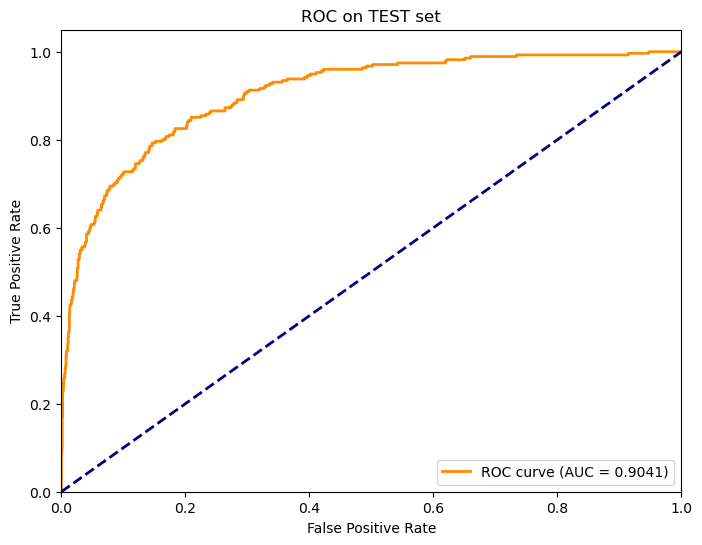

In [88]:
best_estimator = random_search_lgbm.best_estimator_
y_prob = best_estimator.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
best_test_roc_auc = roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on TEST set')
plt.legend(loc='lower right')
plt.show()

In [89]:
# Assuming you have already imported necessary libraries and loaded data
from sklearn.metrics import accuracy_score

# Assuming 'X_test' is your test data and 'y_test' are the corresponding labels
# 'best_estimator' is the model obtained from the randomized search

# Make predictions using the best estimator
y_pred = best_estimator.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=1.7254545454545454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7254545454545454
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy: 0.8976109215017065


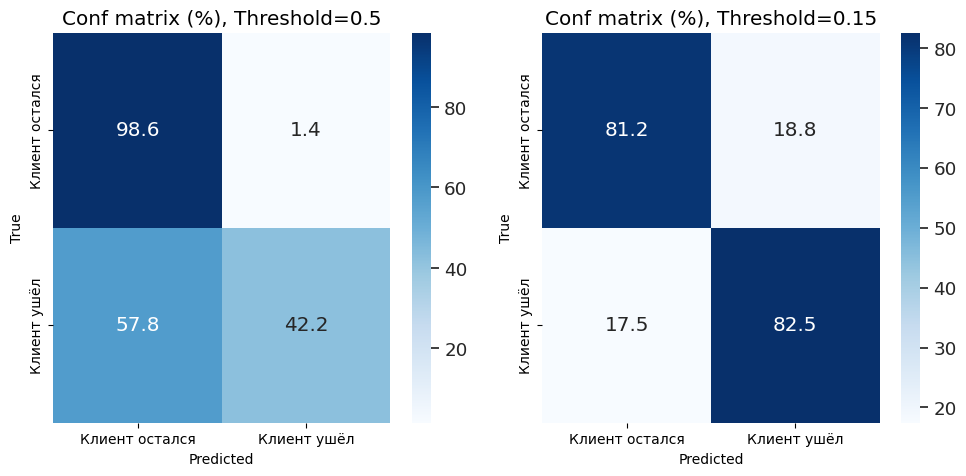

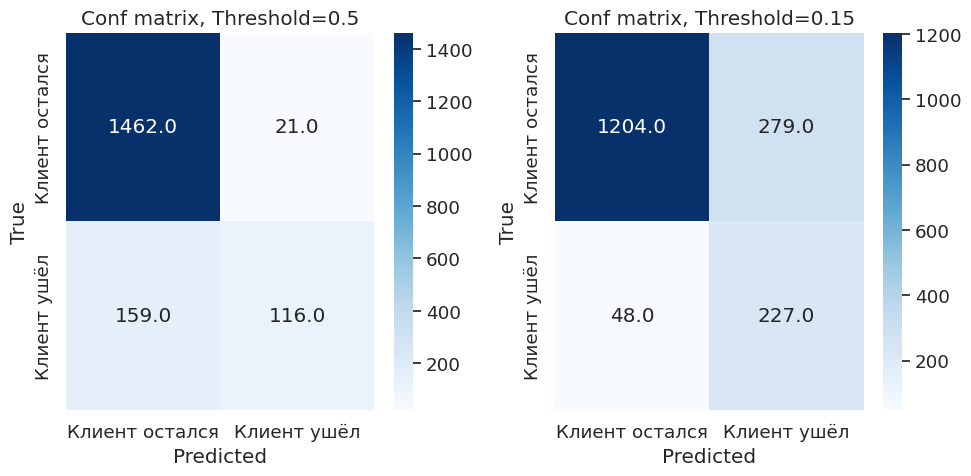

In [90]:
# Thresholds for converting probabilities to binary predictions
thresholds = [0.5, 0.15]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, threshold in enumerate(thresholds):
    # Convert probabilities to binary predictions based on threshold
    y_pred = (y_prob > threshold).astype(int)
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Calculate confusion matrix values as percentages
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
    
    # Plot confusion matrix using Seaborn
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix_percentage, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=["Клиент остался", "Клиент ушёл"],
                yticklabels=["Клиент остался", "Клиент ушёл"],
                ax=axes[i])
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")
    axes[i].set_title(f"Conf matrix (%), Threshold={threshold}")

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, threshold in enumerate(thresholds):
    # Convert probabilities to binary predictions based on threshold
    y_pred = (y_prob > threshold).astype(int)
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix using Seaborn
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=["Клиент остался", "Клиент ушёл"],
                yticklabels=["Клиент остался", "Клиент ушёл"],
                ax=axes[i])
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")
    axes[i].set_title(f"Conf matrix, Threshold={threshold}")

plt.tight_layout()
plt.show()


МАТРИЦА ОШИБОК

В зависимости от порога точность и полноста прогноза может быть разной.

Например, если отсекать вероятность ухода по 0.50, то точность прогноза (tp/(tp+fp)) будет достаточно высокой (около 85%), и вероятность того, что мы спрогнозировали, что клиент уйдёт, но на самом деле он не собирался уходит - низкая (15%). Однако полнота при таком отсечении не очень высока (42%), то есть около половины тех, кто собирается уйти, мы пропустим.

Можно выбрать порог поменьше (0.15), тогда точность станет близкой к 50%, зато мы станем очень редко пропускать тех людей, кто правда собирается уйти. Это можно было бы интерпретировать так: на каждого одного человека, который правда собирается уйти, мы будем дополнительно находить одного ложного, то есть предлагать выгодные условие один лишний раз. Звучит неплохо.

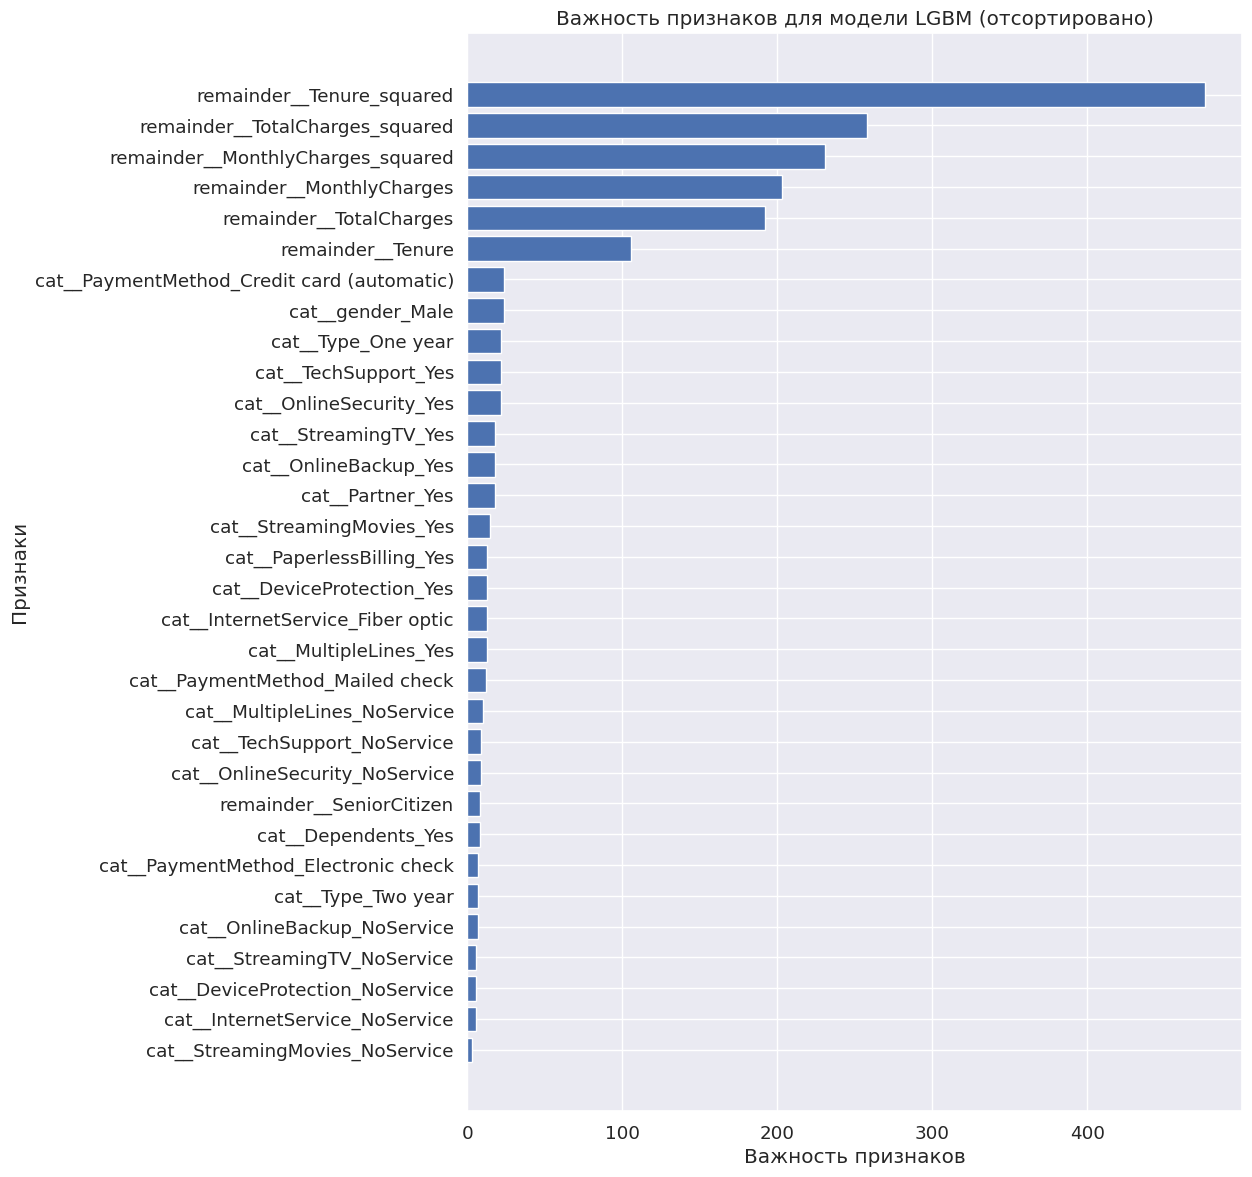

In [91]:
model = random_search_lgbm.best_estimator_.named_steps['model']
preprocessor = random_search_lgbm.best_estimator_.named_steps['preprocessor']
# best_estimator - это лучший обученный пайплайн (А НЕ МОДЕЛЬ!!), 
# и в нем есть ШАГИ - модель ('model'), энкодер ('preprocessor'), скейлер, 
feature_importances = model.feature_importances_ # эта штука лежит в шаге модель
feature_names = preprocessor.get_feature_names_out() # эта штука лежит в шаге препроцессор

# Combine feature names and importances into tuples
feature_tuples = list(zip(feature_names, feature_importances))

# Sort feature tuples by importance
feature_tuples.sort(key=lambda x: x[1], reverse=False)

# Separate sorted feature names and importances
sorted_feature_names = [t[0] for t in feature_tuples]
sorted_feature_importances = [t[1] for t in feature_tuples]

# Create bar plot
plt.figure(figsize=(10, 14))
plt.barh(sorted_feature_names, sorted_feature_importances)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков для модели LGBM (отсортировано)')
plt.show()

Выводы по важности признаков:

Наиболее важными оказались количественные признаки (ежемесячная плата, суммарная плата, время жизни клиента), причем именно столбцы квадратов количественных признаков оказались наиболее значимыми. Видимо, возведение в квадрат позволяет лучше различать нюансы в численных признаках клиентов. Из категориальных признаков наиболее важными оказались признаки оплаты кредитной картой и признак мужского пола.

# Заключительный отчет

### ПРОЕКТ "ПРОГНОЗИРОВАНИЕ ОТТОКА КЛИЕНТОВ"

#### ОПИСАНИЕ ПРОЕКТА

Наш заказчик - оператор связи, предлагающий услуги  интернета, телевидения и телефонии. Заказчик хочет определить клиентов, готовых уйти, чтобы своевременно предложить им более выгодные условия и таким образом удержать клиентов. Желаемая точность предсказания - 0.9 по метрике ROC-AUC.


#### ИСХОДНЫЕ ДАННЫЕ

В качестве данных для исследования нам были предоставлены 4 файла: 'contract_new.csv' с информацией о контрактах с клиентами, 'internet_new.csv' с информацией о подключенных интернет-услугах, 'phone_new.csv' с информацией о подключенных услугах телефонии, 'personal_new.csv' с некоторыми личными данными клиентов. Файлы 'contract_new.csv' и 'personal_new.csv', являющиеся костяком наших данных, содержат всего лишь по 7043 строки, каждая строка - это уникальный клиент. В файле с контрактами для каждого из 7043 клиентов указаны даты начала контракта, дата окончания контракта (либо строка "No", если контракт еще действует), абонентская плата, методы оплаты. В файле с личными данными представлена информация о поле и семейном статусе тех же 7043 клиентов. Остальные два файла с данными об услугах интернета и телефонии содержат меньше строк, так как не у всех клиентов подключены эти услуги. 

Небольшое количество данных склоняет нас к использованию кроссвалидации, чтобы выжать максимум из ограниченного датасета. 


#### ОБРАБОТКА ДАННЫХ

Данные четырех таблиц были объединены в одну таблицу. После присоединения таблиц мы получили пропуски в некоторых строках, где у клиентов не были подключены услуги интернета или телефонной связи, эти пропуски были заполнены строкой "NoService", такой шаг позволяет сберечь информацию о том, что у клиента не подключена та или иная услуга, что может оказаться ценным признаком. Создан целевой столбец Churn на основе столбца EndDate. В датасет были добавлены новые синтетические признаки, например, соотношение между ежемесячной и суммарной платой за услуги ratio, квадраты численных признаков, а также "время жизни клиента". ID клиента был преобразован в индекс и удален из числа признаков за ненадобностью. Столбец EndDate исключен из числа признаков, тк очень сильно коррелирует с целевым признаком, такая же участь постигла и синтетический признак ratio, который сильно коррелировал с другим синтетическим признаком продолжительности жизни клиента.

Категориальные столбцы были преобразованы методом OHE с учетом dummy-ловушки (избыточные столбцы были сброшены). 

Особенностью датасета является явный дисбаланс классов - объектов целевого класса в 6 меньше, чем объектов целевого класса.

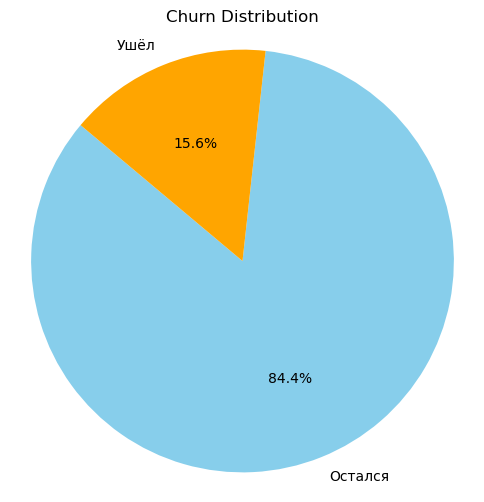

#### МОДЕЛИ

Данные были разделены на обучающую и тестовую выборку. Численные данные были отмасштабированы скейлером, категориальные фичи были приведены OHE. На обучающей по кроссвалидации обучались модели и подбирались гиперпараметры. Модель с лучшим показателем метрики ROC-AUC была затем протестирована на тестовой выборке. При обучении моделей был учтен дисбаланс классов, проблема была решена путем балансировки весов классов и стратификацией при разделении выборки.

В исследовании были использованы модели логистической регрессии и LGBM.

Лучший показатель метрики ROC-AUC на кроссвалидации для модели LogisticRegression составил 0.8297.
Лучший показатель метрики ROC-AUC на кроссвалидации для модели LGBM составил 0.8375181815806435, эта модель была признана лучшей.

##### ЛУЧШАЯ МОДЕЛЬ
Для финального тестирования была выбрана модель LGBM с параметрами

{
'model__max_depth': 53,

 'model__learning_rate': 0.3,
 
 'model__lambda_l2': 1.7254545454545454,
 
 'model__feature_fraction': 0.1}

На тестовой выборке модель LGBM достигла оценки 0.9040850855146203 по метрике ROC-AUC, преодолев таким образом целевой порог 0.9. Точность модели по метрике accuracy составила 0.89, что также является достойным результатом.

#### ВАЖНОСТЬ ПРИЗНАКОВ
Наиболее важными признаками для итоговой модели оказались количественные признаки: время жизни клиента, ежемесячная абонентская плата, общая сумма выплат клиента, и, в особенности, квадраты этих трёх признаков.


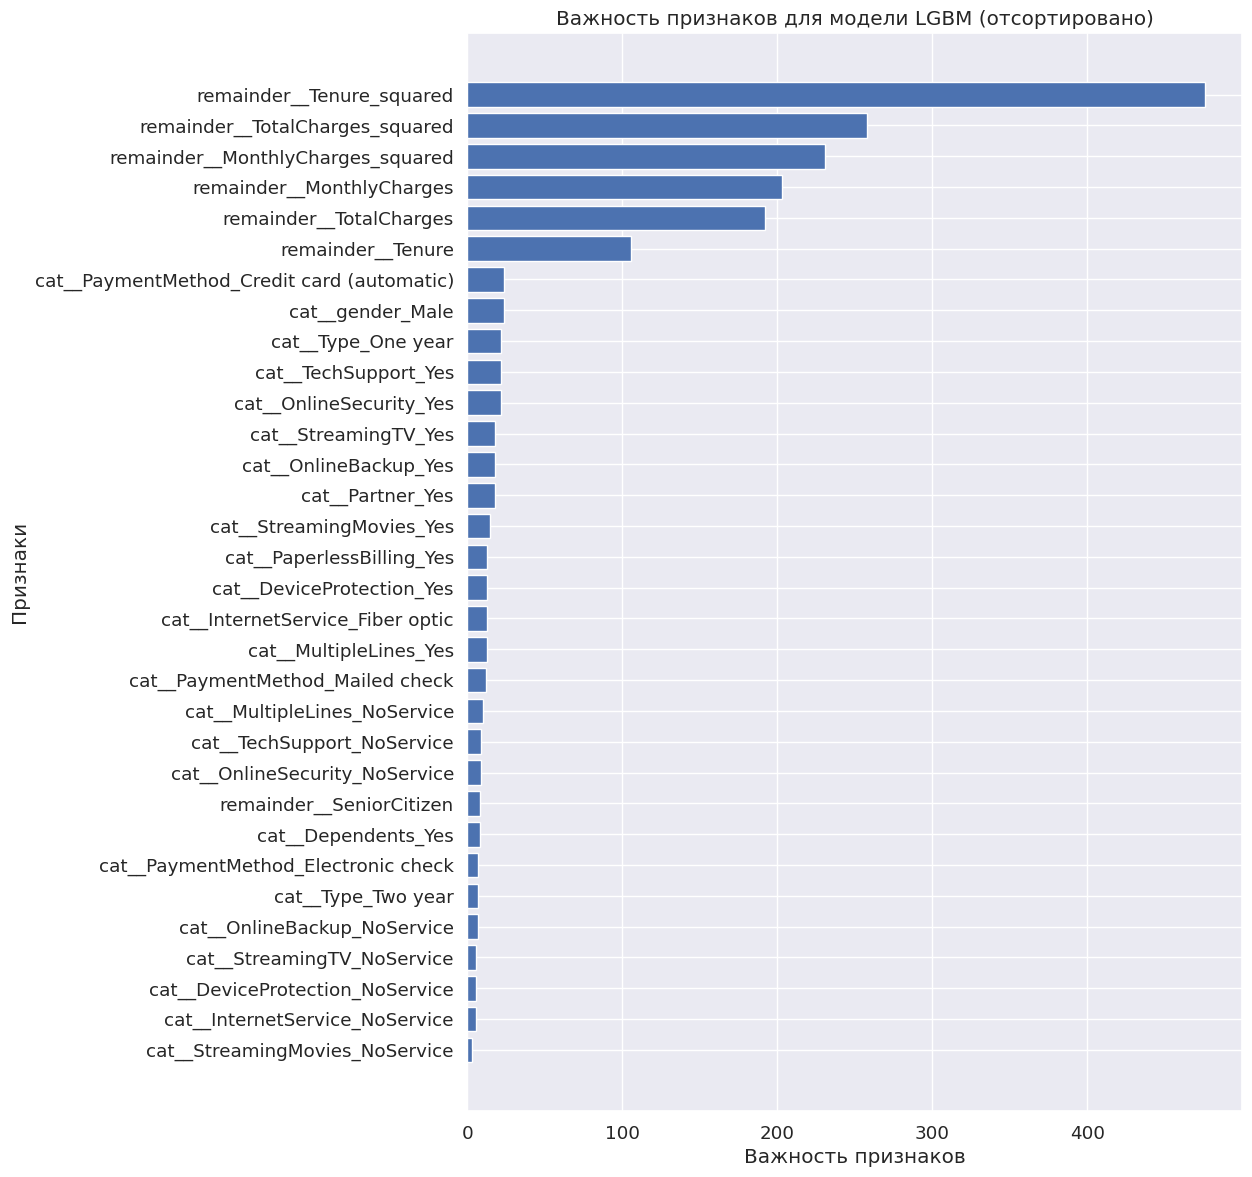

#### ХОД РАБОТЫ
Все основные пункты плана исследования были выполнены: проведен исследовательский анализ данных, созданы новые признаки, проведена проверка на коллинеарность, удалены избыточные или бесполезные столбцы, подготовлены выборки для обучения и тестирования, использованы пайплайны, проведена стандартизировать данные, обучены 2 модели, выбрана лучшая модель и проверена на тестовой выборке. Основное расхождение с первоначальным планом - это отказ от валидационной выборке за ненадобностью.

Были трудности в работе с пайплайном при извлечении признаков, однако с помощью гугл и stackoverflow удалось найти решение.

Ключевыми шагами, на мой взгляд являются создание новых признаков (именно эти признаки оказались наиболее значимыми для модели, каждый из них накинул по проценту-полтора на метрике), масштабирование признаков, нивелирование дисбаланска классов и использование кроссвалидации, позволившей эффективно использовать ограниченные по объему данные. 
